In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import scienceplots
from mpl_toolkits.mplot3d import Axes3D
# plt.style.use(["science", "no-latex"])

from pydrake import symbolic
from pydrake.all import LeafSystem, Simulator, DiagramBuilder, LogVectorOutput, MathematicalProgram, Solve, MakeSemidefiniteRelaxation


In [2]:
# Spacecraft Parameters

# Inertial properties
J = np.diag([100, 200, 300]) # kg*m^2
Jinv = np.linalg.inv(J)

# Torque limits
tau_max = np.array([10, 10, 10]) # N*m

# Initial state vector
x0 = np.array([0, 0, 0, 0.5, 0.5, 0.5, 0.5]) # [w_x, w_y, w_z, q_w, q_x, q_y, q_z]
# Final state vector
xn = np.array([0, 0, 0, 0.0258, 0.0258, 0.0258, 0.999]) # [w_x, w_y, w_z, q_w, q_x, q_y, q_z]

# Camera vector
c = np.array([0, 0, 1]) # Boresight along z
# Sun vector
s = np.array([0.75, 0.433, 0.5])

In [3]:
# Helper functions
def qdot_matrix(q):
    qw, qx, qy, qz = q
    return np.array([
        [-qx, -qy, -qz],
        [qw, -qz, qy],
        [qz, qw, -qx],
        [-qy, qx, qw]
    ])

def euler_eqn(w, u):
    return Jinv @ (u - np.cross(w, J @ w))

def qdot(q, w):
    return 0.5 * qdot_matrix(q) @ w

def qspace(q):
    return np.array([q[4]/q[3], q[5]/q[3], q[6]/q[3]])

In [4]:
# x = [wx, wy, wz, qw, qx, qy, qz]
def satellite_continuous_dynamics(x, u):
    w = x[:3]
    q = x[3:]

    w_dot = euler_eqn(w, u)
    q_dot = qdot(q, w)

    return np.concatenate([w_dot, q_dot])

# Implicit Euler integration for use with solver
def satellite_discrete_dynamics(x, x_next, u, time_step):
    x_dot = satellite_continuous_dynamics(x_next, u)
    residuals = x_next - x - time_step * x_dot
    
    return residuals

In [5]:
# Not actually needed for optimizer
class SpacecraftDynamics(LeafSystem):
    def __init__(self):
        LeafSystem.__init__(self)

        # Declare states
        state_index = self.DeclareContinuousState(7) # 7 states
        self.DeclareStateOutputPort("y", state_index) # 7 outputs
        self.DeclareVectorInputPort("u", 3)  # 3 inputs
    
    def DoCalcTimeDerivatives(self, context, derivatives):
        # Extract the state
        x = context.get_continuous_state_vector().CopyToVector()
        # Extract the input
        u = self.EvalVectorInput(context, 0).CopyToVector()
        # Compute the time derivative
        xdot = self.dynamics(x, u)

        # Set the time derivative of the state
        derivatives.get_mutable_vector().SetFromVector(xdot)

    def dynamics(self, x, u):
        # Define the dynamics of the system
        # xdot = f(x, u)
       
        xdot = satellite_continuous_dynamics(x, u)
        # print(xdot)

        return xdot
    
continuous_system = SpacecraftDynamics()

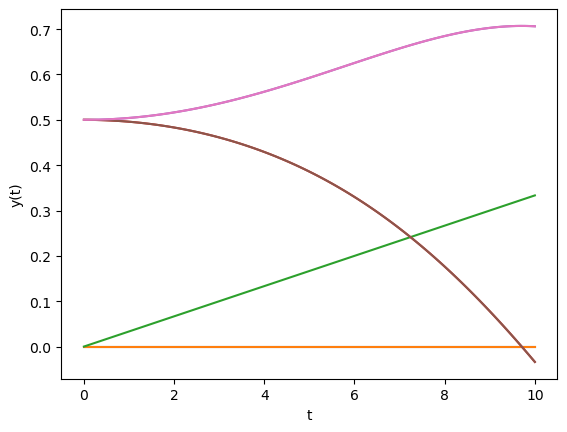

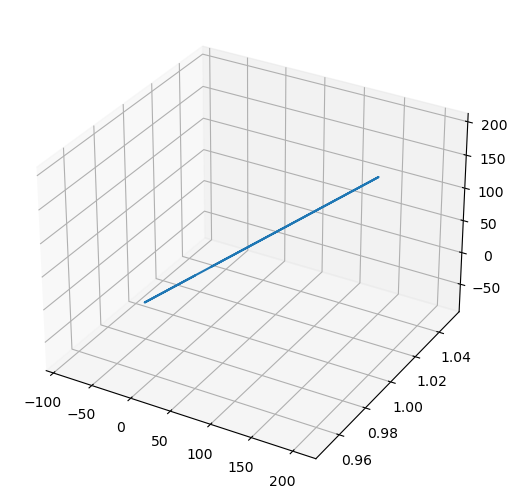

In [6]:
# Create a simple block diagram containing our system.
builder = DiagramBuilder()
system = builder.AddSystem(SpacecraftDynamics())
builder.ExportInput(system.get_input_port())

logger = LogVectorOutput(system.get_output_port(0), builder)
diagram = builder.Build()

# Set the initial conditions, x(0).
context = diagram.CreateDefaultContext()
context.SetContinuousState(x0)

diagram.get_input_port(0).FixValue(context, [0, 0, 10])

# Create the simulator, and simulate for 10 seconds.
simulator = Simulator(diagram, context)
simulator.AdvanceTo(10)

# Plot the results.
log = logger.FindLog(context)
plt.figure()
plt.plot(log.sample_times(), log.data().transpose())
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

# Calculate q space
qspace_vec = [qspace(x) for x in log.data().transpose()]

x = [point[0] for point in qspace_vec]
y = [point[1] for point in qspace_vec]
z = [point[2] for point in qspace_vec]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.plot(x, y, z)
plt.show()

In [16]:
# Mathematical program here
time_interval = 0.1 # Seconds between each time step
time_steps = 10 

prog = MathematicalProgram()

state = prog.NewContinuousVariables(time_steps + 1, 7, "state")
torques = prog.NewContinuousVariables(time_steps + 1, 3, "torques")

# Discretized dynamics
for t in range(time_steps):
    residuals = satellite_discrete_dynamics(state[t], state[t+1], torques[t], time_interval)
    for residual in residuals:
        prog.AddConstraint(residual <= 1e-6)

    prog.AddQuadraticCost(np.eye(3), np.zeros(3), torques[t])


# Initial and final states
prog.AddLinearEqualityConstraint(state[0, :], x0)
prog.AddLinearEqualityConstraint(state[-1, :], xn)


relaxation = MakeSemidefiniteRelaxation(prog=prog)

print(relaxation)

result = Solve(relaxation)
print(result.get_solver_details())
print(result.get_solution_result())
state_opt = result.GetSolution(state)
torques_opt = result.GetSolution(torques)
print(state_opt.shape)

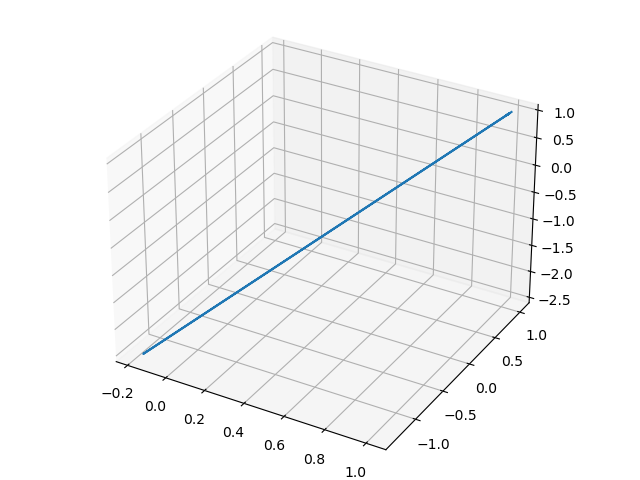

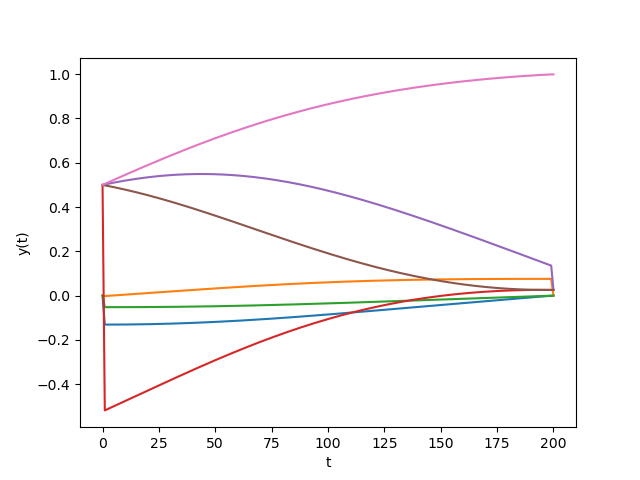

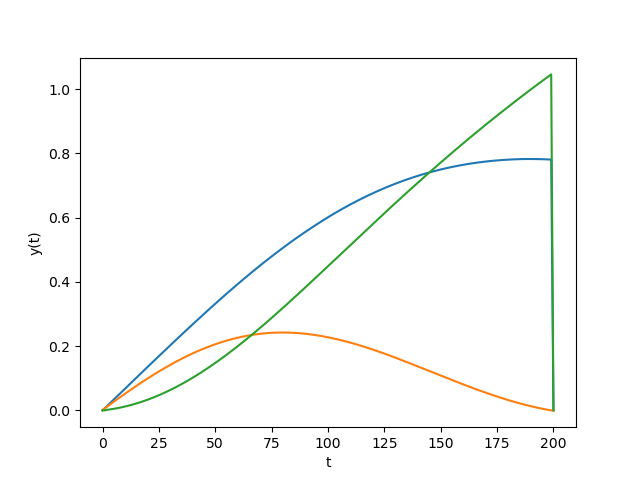

In [14]:
# !pip3 install ipympl
%matplotlib widget

# Calculate q space
qspace_vec = [qspace(x) for x in state_opt.transpose()]

x = [point[0] for point in qspace_vec]
y = [point[1] for point in qspace_vec]
z = [point[2] for point in qspace_vec]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
plt.plot(x, y, z)
plt.show()

plt.figure()
plt.plot(state_opt)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

plt.figure()
plt.plot(torques_opt)
plt.xlabel('t')
plt.ylabel('y(t)')
plt.show()

